In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [9]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data: #['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

# Get the speed of creating files in parallel
def parse_creates(dname):
    runs = []
    for fname in glob.glob(dname + '*/100000/summary-stream.txt'):
        with open(fname) as f:
            d = pd.read_csv(f, names=['job', 'time', 'create'])
            d = d[d['job'] == 'create']
            runs.append(float(d['create'].apply(to_seconds)))
    return runs

def parse_decoupled(runs):
    for run in runs:
        d = pd.read_csv("../results-rerun-run"+str(run)+"-paper/summary.txt", names=csvhead)
        if run == 0: df = d
        df['merge-run-' + str(run)] = d['runtime'].apply(to_seconds)
    df['new_index'] = [4, 3, 2, 1, 0]
    return df.set_index('new_index')

def parse_rpcs(nclient):
    rpcs = pd.DataFrame(columns=["# of Clients", "rpcs"])
    for i in nclient:    
        j1 = parse_mdtest(glob.glob("../../baseline-durability/results-multipleruns/results-cloudlab-clients1-procs" + str(i) + "-nolog-run0/*isolated*"))
        #if i < 20:
        #    j1   = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*isolated*"))
        #else: # the max value we can scale to is 18
        #    j1   = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients18/*isolated*"))
        rpcs.loc[len(rpcs)] = [i, j1] 
    return rpcs

def tput(df, nclient):
    nfiles = [100000*c for c in nclient]
    return nfiles/df

# Total Job Perspective
Shows MDS getting overloaded

- say why we are not using slowest client view: normalization easy to understand using this way
- the difference between speedup and rpc (whether we look at slowest client or all)

nclient=[20, 15, 10, 5, 1]
diffline RPCs=4    5.111773
3    2.894445
2    3.072470
1    3.197262
0    3.366762
dtype: float64
baseline=549.450549451 creates/sec
   clients  RPCs (existing CephFS)  decoupled: create  decoupled: create+merge
4        1                1.144654          20.398876                 5.851212
3        5                4.151474         101.994379                12.016211
2       10                4.509689         203.988757                13.855884
1       15                4.575610         305.983136                14.629423
0       20                4.449400         407.977515                14.980070


,clients,RPCs (existing CephFS),decoupled: create,decoupled: create+merge
0,20,0.039108,0.0,0.018051
1,15,0.029682,0.0,0.037144
2,10,0.035229,0.0,0.042238
3,5,0.007555,0.0,0.031830
4,1,0.000000,0.0,0.015243


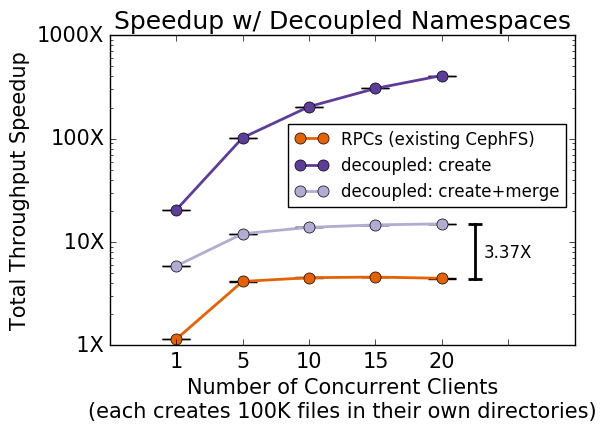

In [16]:
csvhead = ['job', 'nfiles', '# of Clients', 'time', 'runtime']
nclient = [20, 15, 10, 5, 1]
nfiles  = [c*100000 for c in nclient]
runs    = [0, 1, 2]
createL = "decoupled: create"; mergeL = "decoupled: create+merge"; RPCsL = "RPCs (existing CephFS)"
plt_val = [createL, mergeL]
plt_std = [createL+'_stds', mergeL+'_stds']#, 'decoupled_stds']
colors  = ['#f1a340', '#998ec3', '#f7f7f7']

# these all return runtimes, so find mean
#baseline = 100000/np.mean(parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients1/*isolated*")))
baseline = 100000/np.mean(parse_mdtest(glob.glob("../../baseline-durability/results-multipleruns/results-cloudlab-clients1-procs1-log30-run0/*isolated*")))
rpcs = parse_rpcs(nclient)
crts = parse_creates('../../cudele-mechanisms/results-cloudlab-nostream-run')
decp = parse_decoupled(runs)
mean = pd.DataFrame(); stds = pd.DataFrame()
mean['clients'] = rpcs['# of Clients'].astype(int)
stds['clients'] = rpcs['# of Clients'].astype(int)

# calculate throughputs, normalize, and take mean/std
rpc_tput = []
for i, val in zip(range(0, len(rpcs['rpcs'])), rpcs['rpcs']):
    rpc_tput.append([(100000*nclient[i]/v)/baseline for v in val])
mean[RPCsL]     = [np.mean(vals) for vals in rpc_tput]
stds[RPCsL]     = [np.std(vals)  for vals in rpc_tput]

mean[createL]   = tput(np.ones(len(mean))*np.mean(crts), nclient)
stds[createL]   = np.ones(len(stds))*0
mean[createL]   = mean[createL]/ baseline

for i in range(0, 3):
    r = 'merge-run-' + str(i)
    decp[r] += np.ones(len(mean))*np.mean(crts) # add creates
    decp[r] = (100000*decp['# of Clients'])/decp[r] # throughput
    decp[r] = decp[r]/baseline #normalize
mean[mergeL] = decp[['merge-run-' + str(i) for i in range(0, 3)]].mean(axis=1)
stds[mergeL] = decp[['merge-run-' + str(i) for i in range(0, 3)]].std(axis=1)

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
mean = mean.iloc[::-1]
mean[[RPCsL, createL, mergeL]].plot(ax=ax,
       color=['#e66101', '#5e3c99', '#b2abd2'],
       lw=2, marker='o', ms=8,
       yerr=stds[[RPCsL, createL, mergeL]], ecolor='black', capthick=1, capsize=10)

# format
ax.set_xlabel("Number of Concurrent Clients\n(each creates 100K files in their own directories)")
ax.set_xlim(5, -2)
print "nclient="+ str(nclient)
ax.set_xticklabels([""] + [""] + nclient, rotation=0)
ax.set_yscale('log')
ax.set_yticklabels(['{:3.0f}X'.format(x) for x in ax.get_yticks()])
ax.set_title("Speedup w/ Decoupled Namespaces")
ax.set_ylabel("Total Throughput Speedup")

# draw arrow
arrw = dict(facecolor='black', headwidth=0.5, width=0.5, shrink=1)
args = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 12, 'arrowprops': arrw}
ax.axvline(x=-0.5, ymin=0.215, ymax=0.39, lw=2, c='black', marker='_', ms=10, mew=2)
print "diffline RPCs=" + str(mean[mergeL]/mean[RPCsL])
ax.annotate("3.37X", xy=(-1, 8), xytext=(-1, 8), **args)

# remove error bars in legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, bbox_to_anchor=(1, 0.58), loc='center right', fontsize=12,numpoints=2)

fig.savefig('../../../paper/graphs/mergescale.png', bbox_inches='tight', dpi=400)
print "baseline=" + str(baseline) + " creates/sec"
print mean
stds

# Single Client Perspective
But speedup goes negative because metadata server is overloaded

In [7]:
csvhead = ['job', 'nfiles', '# of Clients', 'time', 'runtime']
nclient = [40, 30, 20, 10, 1]
nfiles  = [c*100000 for c in nclient]
runs    = [0, 1, 2]
createL = "decoupled: create"; mergeL = "decoupled: create+merge"; RPCsL = "RPCs (existing CephFS)"
plt_val = [createL, mergeL]
plt_std = [createL+'_stds', mergeL+'_stds']#, 'decoupled_stds']
colors  = ['#f1a340', '#998ec3', '#f7f7f7']

# these all return runtimes, so find mean
baseline = 100000/np.mean(parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients1/*isolated*")))
rpcs = parse_rpcs(nclient)
crts = parse_creates('../../cudele-mechanisms/results-cloudlab-nostream-run')
decp = parse_decoupled(runs)
mean['clients'] = rpcs['# of Clients'].astype(int)
stds['clients'] = rpcs['# of Clients'].astype(int)

# calculate throughputs, normalize, and take mean/std
mean = pd.DataFrame(); stds = pd.DataFrame()
rpc_tput = []
for i, val in zip(range(0, len(rpcs['rpcs'])), rpcs['rpcs']):
    #rpc_tput.append([(100000*nclient[i]/v)/baseline for v in val])
    rpc_tput.append([(100000/v)/baseline for v in val])
mean[RPCsL]     = [np.mean(vals) for vals in rpc_tput]
stds[RPCsL]     = [np.std(vals)  for vals in rpc_tput]

#mean[createL]   = tput(np.ones(len(mean))*np.mean(crts), nclient)
mean[createL]   = np.mean([(100000/c)/baseline for c in np.ones(len(mean))])
stds[createL]   = np.ones(len(stds))*0
#mean[createL]   = mean[createL]/ baseline

for i in range(0, 3):
    r = 'merge-run-' + str(i)
    decp[r] += np.ones(len(mean))*np.mean(crts) # add creates
    #decp[r] = (100000*decp['# of Clients'])/decp[r] # throughput
    decp[r] = 100000/decp[r] # throughput
    decp[r] = decp[r]/baseline #normalize
mean[mergeL] = decp[['merge-run-' + str(i) for i in range(0, 3)]].mean(axis=1)
stds[mergeL] = decp[['merge-run-' + str(i) for i in range(0, 3)]].std(axis=1)

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
mean = mean.iloc[::-1]
mean[[RPCsL, createL, mergeL]].plot(ax=ax,
       color=['#e66101', '#5e3c99', '#b2abd2'],
       lw=2, marker='o', ms=8,
       yerr=stds[[RPCsL, createL, mergeL]], ecolor='black', capthick=1, capsize=10)

# format
ax.set_xlabel("Number of Concurrent Clients\n(each creates 100K files in their own directories)")
ax.set_xlim(5, -1)
ax.set_xticklabels([""] + nclient, rotation=0)
ax.set_yscale('log')
ax.set_yticklabels(['{:3.0f}X'.format(x) for x in ax.get_yticks()])
ax.set_title("Speedup w/ Decoupled Namespaces")
ax.set_ylabel("Throughput Speedup")

# draw arrow
#arrw = dict(facecolor='black', headwidth=0.5, width=0.5, shrink=1)
#args = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 12, 'arrowprops': arrw}
#ax.annotate('baseline: ' + str(int(round(baseline))) + '\ncreates/sec',
#            xy=(4, 1), xytext=(4.2, 3.2), **args)

# remove error bars in legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, bbox_to_anchor=(1, 0.6), loc='center right', fontsize=12,numpoints=2)

#fig.savefig('../../../paper/graphs/mergescale.png', bbox_inches='tight', dpi=400)
print "baseline=" + str(baseline) + " creates/sec"
print mean
stds

UnboundLocalError: local variable 'end' referenced before assignment